# Introduction
In this project, we are doing data analysis for Zuber, a new ride-sharing company that's launching in Chicago.  We will find patterns in data from competitors.  In particular, we will:

- Identify the leading taxi companies.
- Identify the most common neighborhoods for drop-offs.
- Determine whether bad weather has a significant effect on ride duration.

# Preliminary data review
In an earlier phase of the project, we wrote SQL queries to generate the data for our analysis.  We will be working with 3 data sets:

- Number of rides for each taxi company on November 15-16, 2017
- Average number of rides that ended in each neighborhood in November 2017
- Duration of rides from the Loop to O'Hare on Saturdays in November, 2017, with weather conditions

In this section, we will take a preliminary look these 3 datasets.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import levene
import numpy as np
import warnings

warnings.filterwarnings('ignore')

try:
    company = pd.read_csv('project_sql_result_01.csv')
    dest = pd.read_csv('project_sql_result_04.csv')
    ohare = pd.read_csv('project_sql_result_07.csv')
except:
    company = pd.read_csv('/datasets/project_sql_result_01.csv')
    dest = pd.read_csv('/datasets/project_sql_result_04.csv')
    ohare = pd.read_csv('/datasets/project_sql_result_07.csv')

## Number of rides by company
The <code>company</code> dataframe shows the number of rides for each taxi company on November 15-16, 2017.

In [2]:
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [3]:
company.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [4]:
company.tail()

,company_name,trips_amount
59,4053 - 40193 Adwar H. Nikola,7
60,2733 - 74600 Benny Jona,7
61,5874 - 73628 Sergey Cab Corp.,5
62,"2241 - 44667 - Felman Corp, Manuel Alonso",3
63,3556 - 36214 RC Andrews Cab,2


## Average rides by destination
The <code>dest</code> dataframe shows the average number of rides that ended in each neighborhood in November of 2017.

In [5]:
dest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [6]:
dest.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


## Loop to O'Hare
The <code>ohare</code> dataframe shows the starting time, weather conditions, and duration for rides from the Loop to O'Hare International Airport on Saturdays in November, 2017.

In [7]:
ohare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [8]:
ohare.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


## Conclusion
- Company dataframe
    - The <code>company</code> dataframe does not appear to have any missing values.
    - There is a duplication: _Taxi Affiliation Service Yellow_ and _Yellow Cab_.  These are probably the same company, so their data will be consolidated.
    - The data types are appropriate:  <code>string</code> for the company name and <code>int</code> for the number of trips.
    - Companies with few rides, which tend to be smaller companies or individual drivers, have numbers at the beginning of the company name, e.g., "4053 - 40193 Adwar H. Nikola".  This minor inconsistency will not affect our analysis.
- Destination dataframe
    - The <code>dest</code> dataframe, which contains the average number of rides that ended in each neighborhood in November 2017, does not appear to have any missing values. 
    - The destination is a <code>string</code>, and the average number of rides is a <code>float</code>.  It is not important to maintain the precision implied by <code>float</code>, so we will round <code>average_trips</code> and convert it to <code>int</code>.
- O'Hare dataframe
    - The <code>ohare</code> dataframe, which contains the starting hour, weather conditions, and duration for rides from the Loop to O'Hare on Saturdays in November of 2017, has no missing values.
    - We will convert <code>start_ts</code> to <code>datetime</code>, and we will convert <code>duration_seconds</code> to <code>int</code>.

# Preprocessing
First, we will consolidate the two rows representing _Yellow Cab_.

In [9]:
company.loc[company['company_name'] == 'Yellow Cab', 'trips_amount'] += company.loc[company['company_name'] == 'Taxi Affiliation Service Yellow', 'trips_amount'].iloc[0]
company.drop(company.loc[company['company_name'] == 'Taxi Affiliation Service Yellow', 'trips_amount'].index, inplace = True)
company.sort_values(by='trips_amount', ascending=False, inplace=True)
company.head()

,company_name,trips_amount
0,Flash Cab,19558
3,Yellow Cab,19187
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
5,Chicago Carriage Cab Corp,9181


Next, we will make the data type changes identified in the previous section.

In [10]:
dest['average_trips'] = dest['average_trips'].round(0).astype(int)
ohare['start_ts'] = pd.to_datetime(ohare['start_ts'], format='%Y-%m-%d %H:%M:%S')
ohare['duration_seconds'] = ohare['duration_seconds'].astype(int)

## Conclusion
- For the <code>dest</code> dataframe, we consolidated two rows representing _Yellow Cab_, and we converted the average number of trips to an <code>int</code>.
- For the <code>ohare</code> dataframe, we converted the starting time to <code>datetime</code> and converted the ride duration to an <code>int</code>.

# Exploratory data analysis
In this section, we will identify the top 10 taxi companies operating in the Chicago area during November 2017.  We will also identify the top 10 neighborhoods in terms of drop-offs.

## Top taxi companies

In [11]:
total_companies = len(company)
total_trips = company['trips_amount'].sum()
company['percent'] = (100*company['trips_amount']/total_trips).round(1)
print('The data set contains {} companies, with a total of {:,} trips during November 2017.'.format(total_companies, total_trips))
print('The top 10 companies represent {}% of the market.'.format(company[:10]['percent'].sum()))
company.head(10)

The data set contains 63 companies, with a total of 137,311 trips during November 2017.
The top 10 companies represent 76.0% of the market.


,company_name,trips_amount,percent
0,Flash Cab,19558,14.2
3,Yellow Cab,19187,14.0
1,Taxi Affiliation Services,11422,8.3
2,Medallion Leasin,10367,7.6
5,Chicago Carriage Cab Corp,9181,6.7
6,City Service,8448,6.2
7,Sun Taxi,7701,5.6
8,Star North Management LLC,7455,5.4
9,Blue Ribbon Taxi Association Inc.,5953,4.3
10,Choice Taxi Association,5015,3.7


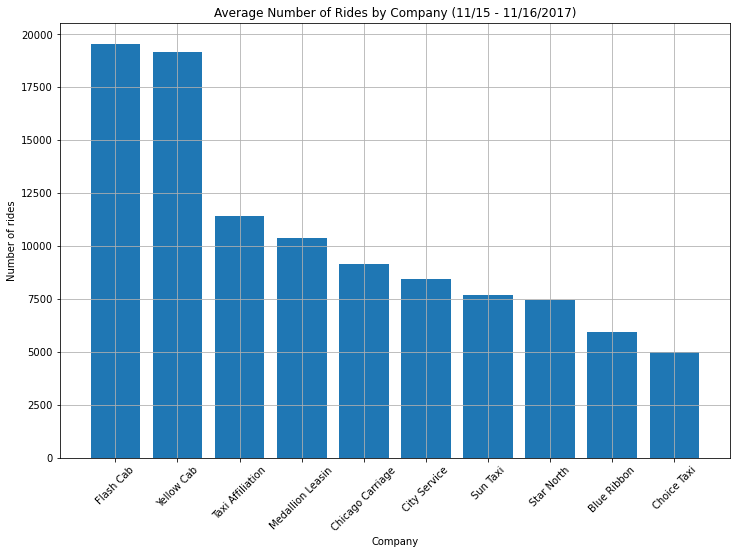

In [12]:
names_shortened = [' '.join(s.split()[0:2]) for s in company['company_name'][:10]] # Abbreviate names to fit on plot
plt.figure(figsize=(12,8))
plt.bar(x=names_shortened, height=company['trips_amount'][:10])
plt.title('Average Number of Rides by Company (11/15 - 11/16/2017)')
plt.xlabel("Company")
plt.ylabel("Number of rides")
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Top neighborhood destinations

In [13]:
total_neighborhoods = len(dest)
total_trips = dest['average_trips'].sum()
dest['percent'] = (100*dest['average_trips']/total_trips).round(1)
print('The data set contains {} destination neighborhoods, with a total of {:,} trips during November 2017.'.format(total_neighborhoods, total_trips))
print('The top 10 neighborhoods represent {}% of the destinations.'.format(dest[:10]['percent'].sum()))
dest.head(10)

The data set contains 94 destination neighborhoods, with a total of 56,396 trips during November 2017.
The top 10 neighborhoods represent 76.7% of the destinations.


,dropoff_location_name,average_trips,percent
0,Loop,10727,19.0
1,River North,9524,16.9
2,Streeterville,6665,11.8
3,West Loop,5164,9.2
4,O'Hare,2547,4.5
5,Lake View,2421,4.3
6,Grant Park,2069,3.7
7,Museum Campus,1510,2.7
8,Gold Coast,1364,2.4
9,Sheffield & DePaul,1260,2.2


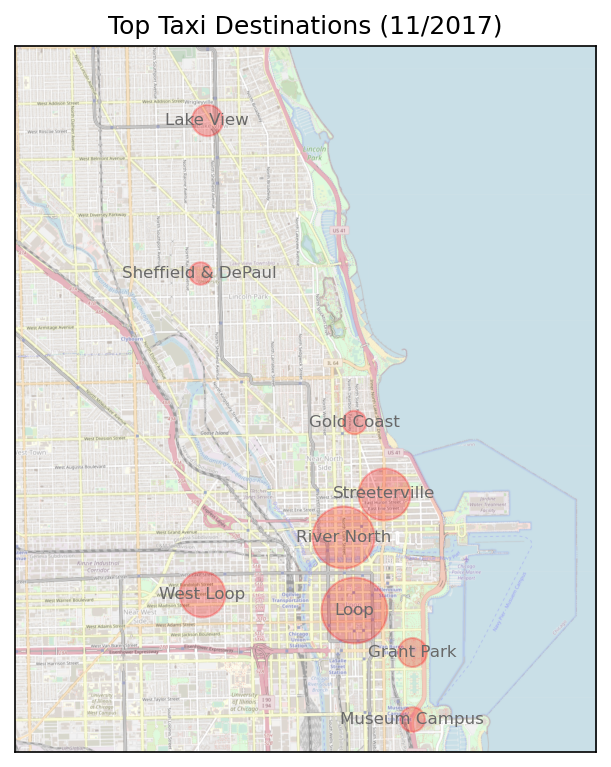

In [14]:
try:
    img = plt.imread('chicago.png')
except:
    import PIL
    import io
    import requests
    img = np.array(
            PIL.Image.open(
                io.BytesIO(
                    requests.get('http://www.reavesmd.com/chicago.png', 
                                 headers={'User-Agent': 'Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36'}
                                ).content
                )
            )
    )
    
img_map = {'Loop':(691,1149),
           'River North':(668,1000),
           'Streeterville':(751,911),
           'West Loop':(380,1115),
           'Lake View':(390,150),
           'Grant Park':(809,1234),
           'Museum Campus':(809,1371),
           'Gold Coast':(691,766),
           'Sheffield & DePaul':(376,462)}

plt.figure(figsize=(5,7), dpi=150)
plt.title('Top Taxi Destinations (11/2017)')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)    

max_diameter = 1000
max_trips = dest['average_trips'].max()

for k, (x, y) in img_map.items():
    s = dest[dest['dropoff_location_name'] == k]['average_trips'] * max_diameter/max_trips
    plt.scatter(x, y, s, c='r', alpha=0.25)
    plt.text(x, y, k, fontsize=8, color='dimgray', horizontalalignment='center', verticalalignment='center')

plt.imshow(img, alpha=0.7)
plt.show()

The figure above shows the top 9 destination neighborhoods.  Labels are placed in the center of each neighborhood based on a review of Google Maps.  The size of the red circle is proportional to the number of rides during the study period.  The other top destination, O'Hare airport, is outside the area represented by the map.  O'Hare is located about 16 miles northwest of the city center.

## Conclusion
- Top taxi companies
    - Flash Cab is the leading taxi company, capturing 14% of trips during the study period.
    - Yellow Cab is similar to Flash Cab in terms of market share.
    - The remaining 72% of the market is divided among more than 60 companies, ranging from larger companies with up to 8% market share to individual owner-operators.
- Top destination neighborhoods
    - The Loop, located in the heart of downtown, was the leading destination, representing 19% of the rides during the study period.
    - O'Hare International Airport was the 4th most popular destination.
    - Generally speaking, downtown areas and O'Hare were frequent destinations.  Other tourist destinations, such as Museum Campus and Streeterville (near Navy Pier) were also popular.

# Statistical data analysis
In this section, we will perform statistical hypothesis tests two answer the following question:

- Is the average duration of rides from the Loop to O'Hare International Airport greater when the weather is bad?

For our hypothesis tests, we will use a signifiance level (alpha) of 0.05. This is a conventional, albeit arbitrary, choice. If we were to choose a higher alpha, such as 0.1, we would increase the risk making a type I error, i.e., mistakenly concluding that there is a difference (rejecting the null hypothesis) when in fact there is no difference. On the other hand, if we were to select a lower alpha, such as 0.01, we would increase the risk of making a type II error, mistakenly concluding that is is no difference (failing to reject the null hypothesis), when in fact there is a difference.

In [15]:
ohare_good = ohare.query('weather_conditions == "Good"')['duration_seconds'].values
print('Good weather: {:.0f} rides with mean ride duration of {:.2f} and variance of {:.2f}'.format(len(ohare_good), ohare_good.mean(), np.var(ohare_good)))

ohare_bad = ohare.query('weather_conditions == "Bad"')['duration_seconds'].values
print('Bad weather: {:.0f} rides with mean ride duration of {:.2f} and variance of {:.2f}'.format(len(ohare_bad), ohare_bad.mean(), np.var(ohare_bad)))

Good weather: 888 rides with mean ride duration of 1999.68 and variance of 575732.93
Bad weather: 180 rides with mean ride duration of 2427.21 and variance of 517403.56


The average ride duration is longer on Saturdays with bad weather, but could this difference be due to chance?  To answer this question, we will construct a hypothesis test.
- **H<sub>0</sub>**: The average ride duration is not longer when weather conditions are bad.
- **H<sub>1</sub>**: The average ride duration is longer when weather conditions are bad.

In [16]:
results = levene(ohare_good, ohare_bad)
if results.pvalue < 0.05:
    print('Levene test: user score distributions do NOT have equal variance. (p={:.2e})'.format(results.pvalue))
else:
    print('Levene test: user score distributions DO have equal variance. (p={:.2e})'.format(results.pvalue))

Levene test: user score distributions DO have equal variance. (p=5.33e-01)


In [17]:
alpha = 0.05
results = st.ttest_ind(ohare_good, ohare_bad, equal_var=True)

# one-sided test: p-value will be halved
print('p-value: {:.2e}'.format(results.pvalue/2))

# one-sided test to the right:
# reject the null hypothesis only if the duration is significantly greater on rainy days
if (results.pvalue/2 < alpha) and (ohare_bad.mean() > ohare_good.mean()):
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.") 

p-value: 3.26e-12
We reject the null hypothesis.


Assuming that the null hypothesis (that the average ride duration not longer when weather is bad) is true, the chance of observing a difference of 427 seconds (about 7 minutes) is almost zero.  Therefore, we conclude that ride duration is longer when the weather is bad.

Our data was limited to Saturdays during November 2017.  Further analysis could be performed to determine the effects of weather on days of the week other than Saturday, other times of the year, and for specific types of weather.

## Conclusion
We performed a one-sided hypothesis test at a significance level of 5% and found that, at least on Saturdays during the month of November 2017, the duration of rides from the Loop to Chicago O'Hare was greater when the weather was bad.

# Conclusion

In this project, we performed data analysis for Zuber, a new ride-sharing company that's launching in Chicago.  In an earlier phase of the project, we queried a database with data from competitors.  This produced three datasets for further analysis.

Our preliminary data review showed few problems with the data, but we did identify a need to consolidate records for Yellow Cab, and to modify the data types for a few fields.  These changes were carried out in the preprocessing phase.

Next we performed exploratory data analysis.  We identified the top 10 taxi companies operating in Chicago.  Flash Cab and Yellow Cab are the leaders, each with about 14% market share.  The rest of the market is split among more than 60 competitors.

We constructed a map showing the leading destination neighborhoods.  The Loop was the most popular destination.  Other downtown areas and tourist spots, and O'Hare International Airport, were also popular destinations.

Finally, we performed a statistical hypothesis test to confirm that, as expected, ride duration increases when the weather is bad.  This analysis could be extended to develop a surge pricing model.